# 데이터 기초 분석

공정 조건과 물성치 간의 대략적인 추세를 살펴보자.

In [1]:
import os
import sys
import json
import pandas as pd
import numpy as np
import scipy.stats as stats
from datetime import datetime

np.set_printoptions(precision=3)
pd.set_option('display.max_rows', None)

import seaborn as sns 
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline
rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = [20, 16]

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio   
import plotly.express as px

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
display(HTML("<style>div.output_scroll { height: 100em; }</style>"))

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

import sklearn.neighbors._base
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base

import re
re_num = re.compile(r'([0-9\.]+)(.*)')

#import env
os.getcwd()

/tmp/ipykernel_17388/2360389780.py:25: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


'/home/ysg/Projects/ai_data_2022-main'

## 데이터 읽기 / 전처리

- 특정 실험(장비, 소재, 적층 방향 동일)의 시편 데이터들 취합하여 비교하기
- 2022-07-11 현재 json 포맷으로 정리되지 않은 정보 존재
- 빈 칸 없애기, 단위 처리 등
- power 와 speed 가 정순으로 기록


<h3> SUS 0degree

In [2]:
base_dir = os.path.join(f'/home', 'mygenie', 'data', 'AI_DB_CYAUTOTECH',)
data_dir_0_1 = os.path.join(base_dir, '2.sus_0_1circle_process', 'CENTER')
base_dir = os.path.join(f'/home', 'mygenie', 'data', 'AI_DB_CYAUTOTECH', '300장비')
data_dir_0_2 = os.path.join(base_dir, '3.sus_0_2circle_process', 'CENTER')

In [3]:
def read_data_0(data_dir):
    data = {}
    json_dir = os.path.join(data_dir, 'JSON')

    for sample_id in os.listdir(json_dir):
        meta_info = None
        json_file = os.listdir(os.path.join(json_dir, sample_id))[0]
        with open(os.path.join(json_dir, sample_id, json_file), encoding='utf-8') as f:
            _info = json.load(f)
            if meta_info is None:
                meta_info = {k:set() for k in _info.keys()}
            for k, v in _info.items():
                if k != 'input 식별자 ':
                    meta_info[k].add(v)
        data[int(sample_id)] = meta_info
    return data

In [4]:
def preprocess_0(data): 
    materials = ['SUS']
    facilities = ['Vulcan 300']

    data_list = []
    for i in range(16):
        _data = {k.strip():list(v)[0].strip() for k, v in data[i].items() if len(v) > 0}

        __data = {}
        for k, v in _data.items():
            if k == '소재':
                __data[k] = materials.index(v)
            elif k == '장비종류':
                __data[k] = facilities.index(v)
            elif k == '적층방향' or k == '데이터셋타입':
                __data[k] = int(v)
            elif 'power' in k:
                __data['laser_speed'] = float(v)## power 와 speed 가 반대로 기록
            elif 'speed' in k:
                __data['laser_power'] = float(v) ## power 와 speed 가 반대로 기록
            else:
                val, unit = re_num.match(v).groups()
                k = k if len(unit) == 0 else f'{k}({unit})'
                __data[k] = float(val)
        data_list.append(__data)
    df = pd.DataFrame(data_list)
    df['laser_density'] = np.divide(df['laser_power'], df['laser_speed']) #df['laser_power'] / df['laser_speed']
    return df

<h3> SUS 45degree

In [5]:
base_dir = os.path.join(f'/home', 'mygenie', 'data', 'AI_DB_CYAUTOTECH', '300장비')
data_dir_45_1 = os.path.join(base_dir, '6.sus_45_1circle_process', 'jsonsort')
data_dir_45_2 = os.path.join(base_dir, '7.sus_45_2circle_process', 'jsonsort')

In [6]:
def read_data_45(data_dir):
    sample_id_list = [int(i) for i in os.listdir(os.path.join(data_dir, 'laseroffset'))]
    
    data = {}
    for sample_id in sample_id_list:
        # laser speed & power
        fname_laser_cond = os.path.join(data_dir, 'laseroffset', str(sample_id), 'laseroffset.txt')
        with open(fname_laser_cond) as f:
            lines = f.readlines()
        laser_cond = {k:v for k, v in [s.strip().split(':') for s in lines]}

        # mechanical properties
        with open(os.path.join(data_dir, 'sub', f'{sample_id+1}.txt'), encoding='utf-8-sig') as f:
            lines = f.readlines()
        prop = {k:v for k, v in [s.strip().split(':') for s in lines]}

        data[sample_id] = prop
        data[sample_id].update(laser_cond)
    return data

In [7]:
def preprocess_45(data): 
    # materials = ['SUS']
    # facilities = ['Vulcan 300']
    data_list = []
    for i in range(16):
        _data = data[i]

        __data = {}
        for k, v in _data.items():
            if k == 'power':
                __data['laser_power'] = float(v)     ## power 와 speed 
            elif k == 'speed':
                __data['laser_speed'] = float(v)     ## power 와 speed 
            else:
                val, unit = re_num.match(v).groups()
                k = k if len(unit) == 0 else f'{k}({unit})'
                __data[k] = float(val)

        data_list.append(__data)
    df = pd.DataFrame(data_list)
    df['laser_density'] = df['laser_power'] / df['laser_speed']
    return df

In [8]:
list_file = [data_dir_0_1, data_dir_0_2] + [data_dir_45_1, data_dir_45_2]
list_data = list()
list_df = list()
for _file in list_file:
    if 'sus_0_' in _file:
        _data = read_data_0(_file)
        _df = preprocess_0(_data)
        _df['main_axis'] = '0'
    else:
        _data = read_data_45(_file)
        _df = preprocess_45(_data)
        _df['main_axis'] = '45'
    list_data.append(_data)
    list_df.append(_df)

# 데이터 분석

In [24]:
def plot_annot(df_plot, x_col, y_cols, figsize=(24, 5), ax=list(), marker='o', color='tab:blue', alpha=0.7, offset=0.0, label='1'):
    
    if len(ax) <= 0: 
        fig, ax = plt.subplots(1, len(y_cols), figsize=figsize)
    for i, c in enumerate(y_cols):
        x = df_plot[x_col]
        y = df_plot[c]
        ax[i].scatter(x, y, marker=marker, c=color, alpha=alpha, label=label)
        ax[i].set_title(c)
        ax[i].set_xlabel(x_col)

        xscale = (x.max()-x.min()) 
        yscale = (y.max()-y.min())
        xoffset = offset * xscale
        yoffset = offset * yscale
        for (_idx, _x, _y) in zip(x.index, x, y):
            ax[i].annotate(_idx, (_x+xoffset, _y+yoffset), c=color)
        ax[i].legend(loc='lower right')
            

def plot_annot_comp(df_0, df_1, x_col, y_cols, figsize=(24, 5), label=['1','2']):
    fig, ax = plt.subplots(1, len(y_cols), figsize=figsize)
    plot_annot(df_0, x_col, y_cols, figsize=figsize, ax=ax, marker='o', color='tab:blue', alpha=0.7, offset=-0.04, label=label[0])
    plot_annot(df_1, x_col, y_cols, figsize=figsize, ax=ax, marker='^', color='tab:red', alpha=0.7, offset=0.01, label=label[1])

## 이상치 제외 

sus_0_1 : 0, 6, 7
sus_0_2 : 1, 2, 12
sus_45_1 : 1, 12
sus_45_2 : 0, 4, 12

In [10]:
_idx_0_1 = [True] * 16; _idx_0_1[0] = False; _idx_0_1[6] = False; _idx_0_1[7] = False
_idx_0_2 = [True] * 16; _idx_0_2[1] = False; _idx_0_2[2] = False; _idx_0_2[12] = False
_idx_45_1 = [True] * 16; _idx_45_1[1] = False; _idx_45_1[12] = False
_idx_45_2 = [True] * 16; _idx_45_2[0] = False; _idx_45_2[4] = False; _idx_45_2[12] = False
list_abnormal = [ _idx_0_1, _idx_0_2, _idx_45_1, _idx_45_2 ]
list_df_re = list()
for (_df, _idx) in zip(list_df, list_abnormal):
    for col in _df.columns:
        _df.loc[np.logical_not(_idx), col] = np.nan
    list_df_re.append(_df)    

In [11]:
y_cols = ['항복강도(MPa)','인장강도(MPa)','연신율(%)', '밀도',]
x_cols = ['laser_power', 'laser_speed','laser_density', 'main_axis']

In [12]:
df_all = pd.concat(list_df_re, ignore_index=True) #.dropna()
df_all = df_all[y_cols+x_cols].dropna()
df_all

,항복강도(MPa),인장강도(MPa),연신율(%),밀도,laser_power,laser_speed,laser_density,main_axis
1,476.22,611.24,40.4,7.82,264.0,700.0,0.377143,0
2,466.05,602.48,42.7,7.82,360.0,700.0,0.514286,0
3,483.13,599.35,40.8,7.80,408.0,700.0,0.582857,0
4,469.09,577.51,39.2,7.82,264.0,900.0,0.293333,0
5,423.57,533.57,32.7,7.82,312.0,900.0,0.346667,0
8,466.94,587.99,35.0,7.80,264.0,1100.0,0.240000,0
9,457.77,574.32,34.6,7.83,312.0,1100.0,0.283636,0
10,492.27,612.01,32.7,7.86,360.0,1100.0,0.327273,0
11,469.23,581.53,34.6,7.78,408.0,1100.0,0.370909,0
12,440.42,551.60,34.6,7.83,360.0,1300.0,0.276923,0


In [ ]:
## 전체 데이터 분석

In [13]:
y_cols = ['항복강도(MPa)','인장강도(MPa)','연신율(%)'] #,'밀도']
x_cols = ['laser_power', 'laser_speed', 'main_axis'] #,'laser_density']

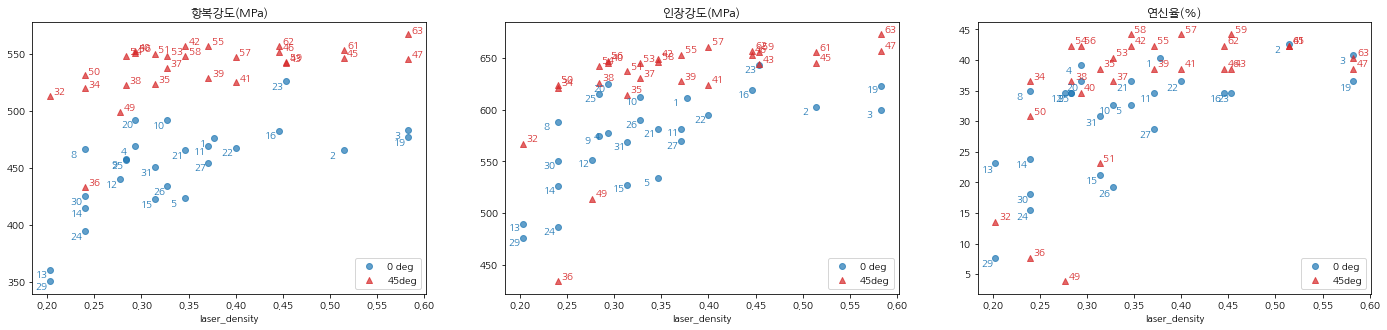

In [25]:
plot_annot_comp(df_all.loc[df_all['main_axis']=='0'], df_all.loc[df_all['main_axis']=='45'], 'laser_density', y_cols, label=['0 deg', '45deg'])

## model 

In [26]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pio.renderers.default = "notebook"

def cal_mape(y_pred, y_real):
    non_zero = np.where(y_real != 0.0)
    out = np.abs(np.divide((y_pred[non_zero] - y_real[non_zero]), y_real[non_zero]))
    return np.nansum(out) / (out.shape[0]) * 100

def plotly_compact(data, title=None, static=True, xdata=None):
    fig = make_subplots()
    for key, val in data.items():
        if xdata is None:
            fig.add_trace(go.Scatter(y=val, name=key))
        else:
            fig.add_trace(go.Scatter(x=xdata[key], y=val, name=key))
            
    _layout_dict = dict()
    if title:
        _layout_dict['title'] = title
    #_layout_dict['yaxis'] = dict(range=[750, 1050 ],)
    #_layout_dict['xaxis'] = dict(range=[17350, 17850],)

    if static:
        _layout_dict['width'] = 1600
        fig.update_layout(_layout_dict)
        fig.show(renderer="png")  
    else:
        fig.update_layout(_layout_dict)
        fig.show()
        
    
def plotly_secondary_y(data, cols_y1, cols_y2=None, xdata=None, static=False, title=None,):
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    flag_y2 = [False] * len(cols_y1) 
    if cols_y2: 
        flag_y2 += [True] * len(cols_y2)
    cols = cols_y1 + cols_y2 
    
    for key, f in zip(cols, flag_y2):
        if xdata is None:
            fig.add_trace(go.Scatter(y=data[key], name=key, mode='markers'), secondary_y = f)
        else:
            fig.add_trace(go.Scatter(x=data[xdata], y=data[key], name=key, mode='markers'), secondary_y = f)
            
    _layout_dict = dict()
    if title:
        _layout_dict['title'] = title

    if static:
        _layout_dict['width'] = 1600
        fig.update_layout(_layout_dict)
        fig.show(renderer="png")  
    else:
        fig.update_layout(_layout_dict)
        fig.show()

        
    
def plotly_secondary_y_2(data, data2, cols_y1, cols_y2=None, xdata=None, static=False, title=None,):
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    flag_y2 = [False] * len(cols_y1) 
    if cols_y2: 
        flag_y2 += [True] * len(cols_y2)
    cols = cols_y1 + cols_y2 
    
    for key, f in zip(cols, flag_y2):
        if f: 
            _data = data2
        else: 
            _data = data
        if xdata is None:
            fig.add_trace(go.Scatter(y=_data[key], name=key, mode='markers'), secondary_y = f)
        else:
            fig.add_trace(go.Scatter(x=_data[xdata], y=_data[key], name=key, mode='markers'), secondary_y = f)
            
    _layout_dict = dict()
    if title:
        _layout_dict['title'] = title

    if static:
        _layout_dict['width'] = 1600
        fig.update_layout(_layout_dict)
        fig.show(renderer="png")  
    else:
        fig.update_layout(_layout_dict)
        fig.show()
          
        
def check_distribution(x_train, x_test, tag):
    nrow = 2
    ncol = int(np.floor(x_train.shape[-1] / nrow)) + 1
    fig = plt.figure(figsize=(6*ncol, 6*nrow))
    axes = fig.subplots(nrow, ncol, sharey=False).flatten()
    
    mode = 'train'
    for k in range(x_train.shape[-1]):
        sns.distplot(x_train[:,k], label=mode, ax=axes[k])
        axes[k].set_title(tag[k])
        axes[k].legend(loc='upper right')
    mode = 'test'
    for k in range(x_test.shape[-1]):
        sns.distplot(x_test[:,k], label=mode, ax=axes[k])
        axes[k].set_title(tag[k])
        axes[k].legend(loc='upper right')


In [27]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.inspection import permutation_importance
from munch import Munch

In [28]:
label_encoder = LabelEncoder()
label_encoder.fit(df_all['main_axis'])
df_all['main_axis_cls'] = label_encoder.transform(df_all['main_axis'])

(53, 3) (53,)
R2 score(train): 0.9573595877621277
R2 score(test): 0.5888894111572807
mape(train): 1.2757321355926778
mape(test): 5.664933829069785


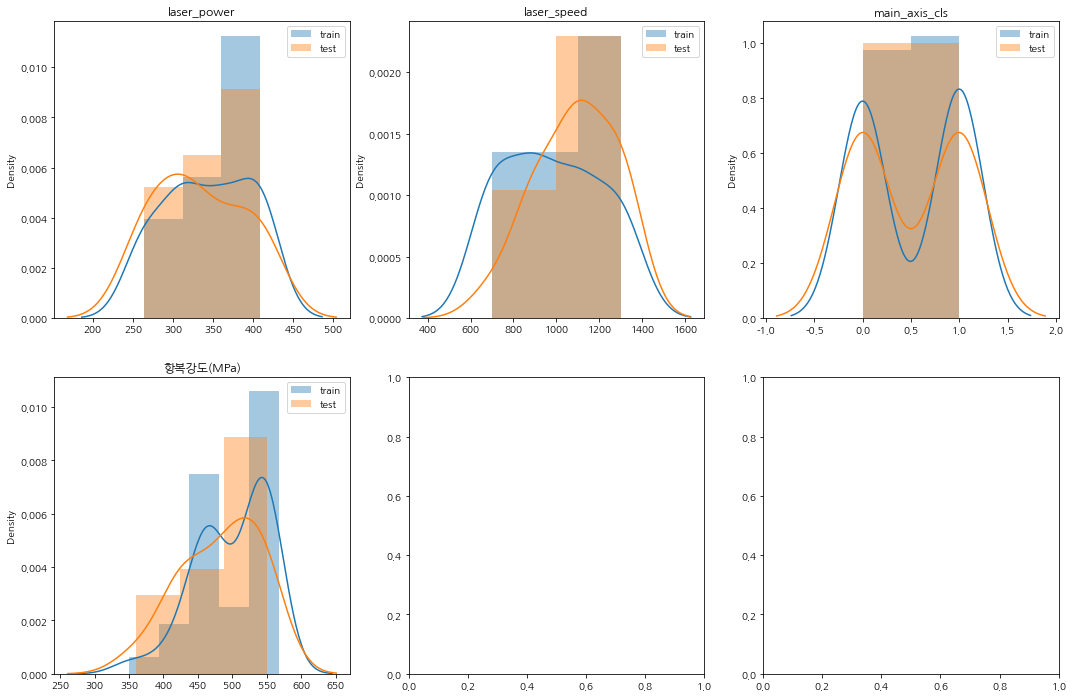

In [33]:
tag_picked = ['laser_power', 'laser_speed', 'main_axis_cls'] #,'laser_density']
tag_target = ['항복강도(MPa)'] #,'인장강도(MPa)','연신율(%)','밀도'


x_data = np.array(df_all[tag_picked])
y_data = np.array(df_all[tag_target]).ravel()
print(x_data.shape, y_data.shape)
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.3, shuffle=True)
check_distribution(np.concatenate([x_train, np.expand_dims(y_train, -1)], axis=1), 
                   np.concatenate([x_test, np.expand_dims(y_test, -1)], axis=1), 
                   tag_picked+tag_target)

model = GradientBoostingRegressor( learning_rate=0.1, n_estimators=100, subsample=0.5, max_depth=5) #subsample=1.0, max_depth=3
model.fit(x_train, y_train)
y_pred_train = model.predict(x_train)
y_predict = model.predict(x_test)

print('R2 score(train):', model.score(x_train, y_train))
print('R2 score(test):', model.score(x_test, y_test))
print('mape(train):',cal_mape(y_pred_train, y_train))
print('mape(test):',cal_mape(y_predict, y_test))

df_summary = Munch( 
    x_train = x_train, 
    x_test = x_test, 
    y_train = y_train, 
    y_test = y_test, 
    y_train_pred = y_pred_train, 
    y_test_pred = y_predict)
df_y = Munch( real = np.concatenate([y_train, y_test]), predicted = np.concatenate([y_pred_train, y_predict]))
plotly_compact(df_y, title=None, static=False, xdata=None)


In [40]:
def plot_annot_data(df_x, df_y, x_cols, y_cols, figsize=(24, 5), ax=list(), marker='o', color='tab:blue', alpha=0.7, offset=0.0, label='1'):
    
    if len(ax) <= 0: 
        fig, ax = plt.subplots(1, len(x_cols), figsize=figsize)
    for i, c in enumerate(x_cols):
        x = df_x[:, i]
        y = df_y
        ax[i].scatter(x, y, marker=marker, c=color, alpha=alpha, label=label)
        ax[i].set_title(y_cols[0])
        ax[i].set_xlabel(c)

        xscale = (x.max()-x.min()) 
        yscale = (y.max()-y.min())
        xoffset = offset * xscale
        yoffset = offset * yscale
        for _idx, (_x, _y) in enumerate(zip(x, y)):
            ax[i].annotate(_idx, (_x+xoffset, _y+yoffset), c=color)
        ax[i].legend(loc='lower right')

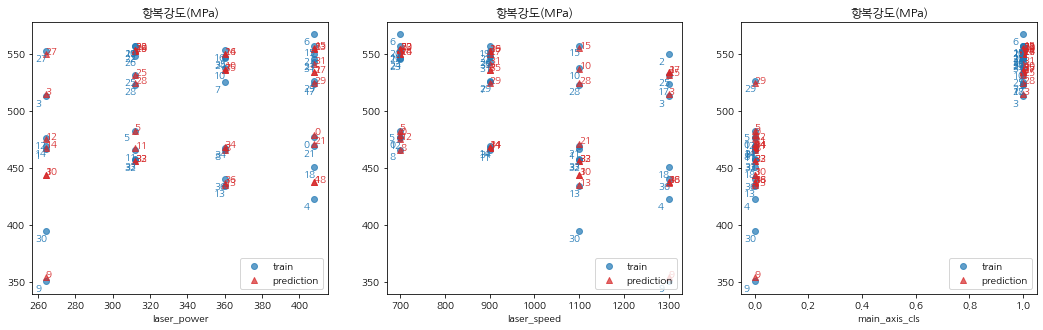

In [42]:
df_summary
df_summary = Munch( 
    x_train = x_train, 
    x_test = x_test, 
    y_train = y_train, 
    y_test = y_test, 
    y_train_pred = y_pred_train, 
    y_test_pred = y_predict)

fig, ax = plt.subplots(1, len(tag_picked), figsize=(18, 5))
plot_annot_data(df_summary.x_train, df_summary.y_train, tag_picked, tag_target, ax=ax, label='train', marker='o', color='tab:blue', alpha=0.7, offset=-0.04)
plot_annot_data(df_summary.x_train, df_summary.y_train_pred, tag_picked, tag_target, ax=ax, label='prediction', marker='^', color='tab:red', alpha=0.7, offset=0.0)

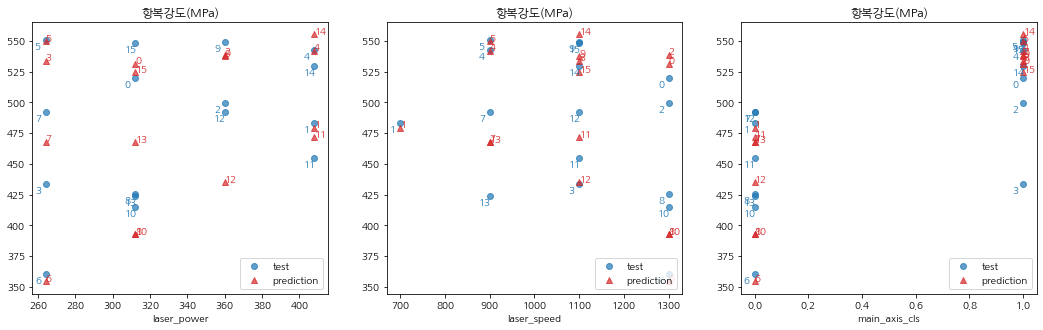

In [43]:
fig, ax = plt.subplots(1, len(tag_picked), figsize=(18, 5))
plot_annot_data(df_summary.x_test, df_summary.y_test, tag_picked, tag_target, ax=ax, label='test', marker='o', color='tab:blue', alpha=0.7, offset=-0.04)
plot_annot_data(df_summary.x_test, df_summary.y_test_pred, tag_picked, tag_target, ax=ax, label='prediction', marker='^', color='tab:red', alpha=0.7, offset=0.0)